In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from datetime import datetime
from datetime import timedelta
from scipy.stats import linregress

In [2]:
### load COVID-19 cases data from git repository by John Hopkins University 
# https://github.com/CSSEGISandData/COVID-19

path = '/kp/kpbkp/tgeiger/data/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
data = pd.read_csv(path).iloc[:,1:] # delete province/state level
geometry = [Point(xy) for xy in zip(data.Long, data.Lat)]
crs = {'init': 'epsg:4326'}  # inital projection of data
data_gpd = GeoDataFrame(data, crs=crs, geometry=geometry)
del data_gpd['Lat']; del data_gpd['Long']
data_gpd.rename(columns={'Country/Region': 'country'}, inplace=True)
# aggregate admin 2 data to admin 1 level
print(data_gpd.shape)
#data_gpd=data_gpd.groupby('country').sum().reset_index()
data_gpd=data_gpd.dissolve(by='country', aggfunc='sum').reset_index()
print(data_gpd.shape)
data_gpd[:5]

(253, 69)
(177, 69)


,country,geometry,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,Afghanistan,POINT (65 33),0,0,0,0,0,0,0,0,...,22,24,24,40,40,74,84,94,110,110
1,Albania,POINT (20.1683 41.1533),0,0,0,0,0,0,0,0,...,64,70,76,89,104,123,146,174,186,197
2,Algeria,POINT (1.6596 28.0339),0,0,0,0,0,0,0,0,...,87,90,139,201,230,264,302,367,409,454
3,Andorra,POINT (1.5218 42.5063),0,0,0,0,0,0,0,0,...,53,75,88,113,133,164,188,224,267,308
4,Angola,POINT (17.8739 -11.2027),0,0,0,0,0,0,0,0,...,0,1,2,2,3,3,3,4,4,5


In [3]:
### load COVID-19 deaths data from git repository by John Hopkins University 
# https://github.com/CSSEGISandData/COVID-19

path = '/kp/kpbkp/tgeiger/data/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(path).iloc[:,1:] # delete province/state level
geometry = [Point(xy) for xy in zip(death.Long, death.Lat)]
crs = {'init': 'epsg:4326'}  # inital projection of data
death_gpd = GeoDataFrame(death, crs=crs, geometry=geometry)
del death_gpd['Lat']; del death_gpd['Long']
death_gpd.rename(columns={'Country/Region': 'country'}, inplace=True)
# aggregate admin 2 data to admin 1 level
print(death_gpd.shape)
death_gpd=death_gpd.dissolve(by='country', aggfunc='sum').reset_index()
print(death_gpd.shape)
death_gpd[:5]

(253, 69)
(177, 69)


,country,geometry,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,Afghanistan,POINT (65 33),0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,2,4,4,4
1,Albania,POINT (20.1683 41.1533),0,0,0,0,0,0,0,0,...,2,2,2,2,4,5,5,6,8,10
2,Algeria,POINT (1.6596 28.0339),0,0,0,0,0,0,0,0,...,9,11,15,17,17,19,21,25,26,29
3,Andorra,POINT (1.5218 42.5063),0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,3,3,3
4,Angola,POINT (17.8739 -11.2027),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


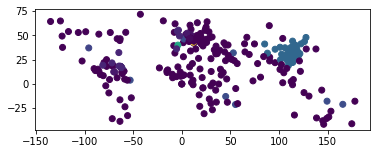

In [7]:
death_gpd.plot(column='3/28/20')

In [34]:
def doubling_time(sub_sample, inc, datatype):
    el=0
    slope_ls=[]
    while el+inc < len(sub_sample):

        s,i,r,p,std = linregress(sub_sample.index[el:el+inc], np.log2(sub_sample[datatype][el:el+inc]))
        #print (el, s, 1/s)
        slope_ls.append(1/s)
        el=el+1
    return slope_ls
        #plt.plot(xx[:el+inc],xx[:el+inc]*s+i)

def plot_cty(ctyls, datatypels, inc, case_th, death_th, save=False):
    colorls=['b','r']
    # make figure + axes
    fig, axs = plt.subplots(len(ctyls),len(datatypels)+1,figsize=(5*(len(datatypels)+1),5*len(ctyls)),tight_layout=True)
    for ctyno, cty in enumerate(ctyls):
        for datano, datatype,color in zip(range(len(datatypels)),datatypels,colorls):
            if datatype=='cases':
                sample=data_gpd[data_gpd['country'].str.contains(cty)==True].iloc[:,2:].T
            elif datatype=='deaths':
                sample=death_gpd[data_gpd['country'].str.contains(cty)==True].iloc[:,2:].T
                #datano=datano+1
            else:
                print('{0} not defined. Aborted!'.format(datatype))
                break
            sample.index=pd.to_datetime(sample.index)
            sample.columns=[datatype]
            # first plot and third plot
            axs[ctyno,2*datano].set_xlabel('time')
            axs[ctyno,2*datano].set_ylabel('{0} > 10'.format(datatype))
            axs[ctyno,2*datano].set_title(cty)
            if datatype=='cases':
                sub_sample=sample[sample[datatype] > case_th]
            elif datatype=='deaths':
                sub_sample=sample[sample[datatype] > death_th]
            axs[ctyno,2*datano].set_xlim([sub_sample.index[0]- timedelta(days=1),sub_sample.index[-1]+ timedelta(days=1)])
            axs[ctyno,2*datano].bar(sub_sample.index, sub_sample.iloc[:,0], color=color)
            [lab.set_rotation(30) for lab in axs[ctyno,2*datano].get_xticklabels()]

            # second plot, doubling time of cases and deaths
            axs[ctyno,1].set_xlabel('time')
            axs[ctyno,1].set_ylabel('last {0} days-estimated doubling time in days'.format(inc))
            axs[ctyno,1].set_ylim([1.8,12])
            axs[ctyno,1].set_title(cty)
            sub_sample=sub_sample.reset_index()
            xx=sub_sample.index
            axs[ctyno,1].plot(sub_sample['index'][inc:],doubling_time(sub_sample=sub_sample, inc=inc, datatype=datatype),'-o', color=color, label=datatype)
            [lab.set_rotation(30) for lab in axs[ctyno,1].get_xticklabels()]

            print ('total {0}: {1} since '.format(datatype,sample.iloc[-1,0]), sample.index[0])
        print ('last update {0}'.format(sample.index[-1]))
        axs[ctyno,1].legend()
    if save==True:
        plt.savefig('/kp/kpbkp/tgeiger/data/corona/COVID-19_doubling-time_analysis_by_country.pdf')#.format(datatype))
    #print (sample)

total cases: 92472 since  2020-01-22 00:00:00
total deaths: 10023 since  2020-01-22 00:00:00
last update 2020-03-28 00:00:00
total cases: 57695 since  2020-01-22 00:00:00
total deaths: 433 since  2020-01-22 00:00:00
last update 2020-03-28 00:00:00
total cases: 73235 since  2020-01-22 00:00:00
total deaths: 5982 since  2020-01-22 00:00:00
last update 2020-03-28 00:00:00
total cases: 38105 since  2020-01-22 00:00:00
total deaths: 2317 since  2020-01-22 00:00:00
last update 2020-03-28 00:00:00
total cases: 121478 since  2020-01-22 00:00:00
total deaths: 2026 since  2020-01-22 00:00:00
last update 2020-03-28 00:00:00
total cases: 17312 since  2020-01-22 00:00:00
total deaths: 1021 since  2020-01-22 00:00:00
last update 2020-03-28 00:00:00


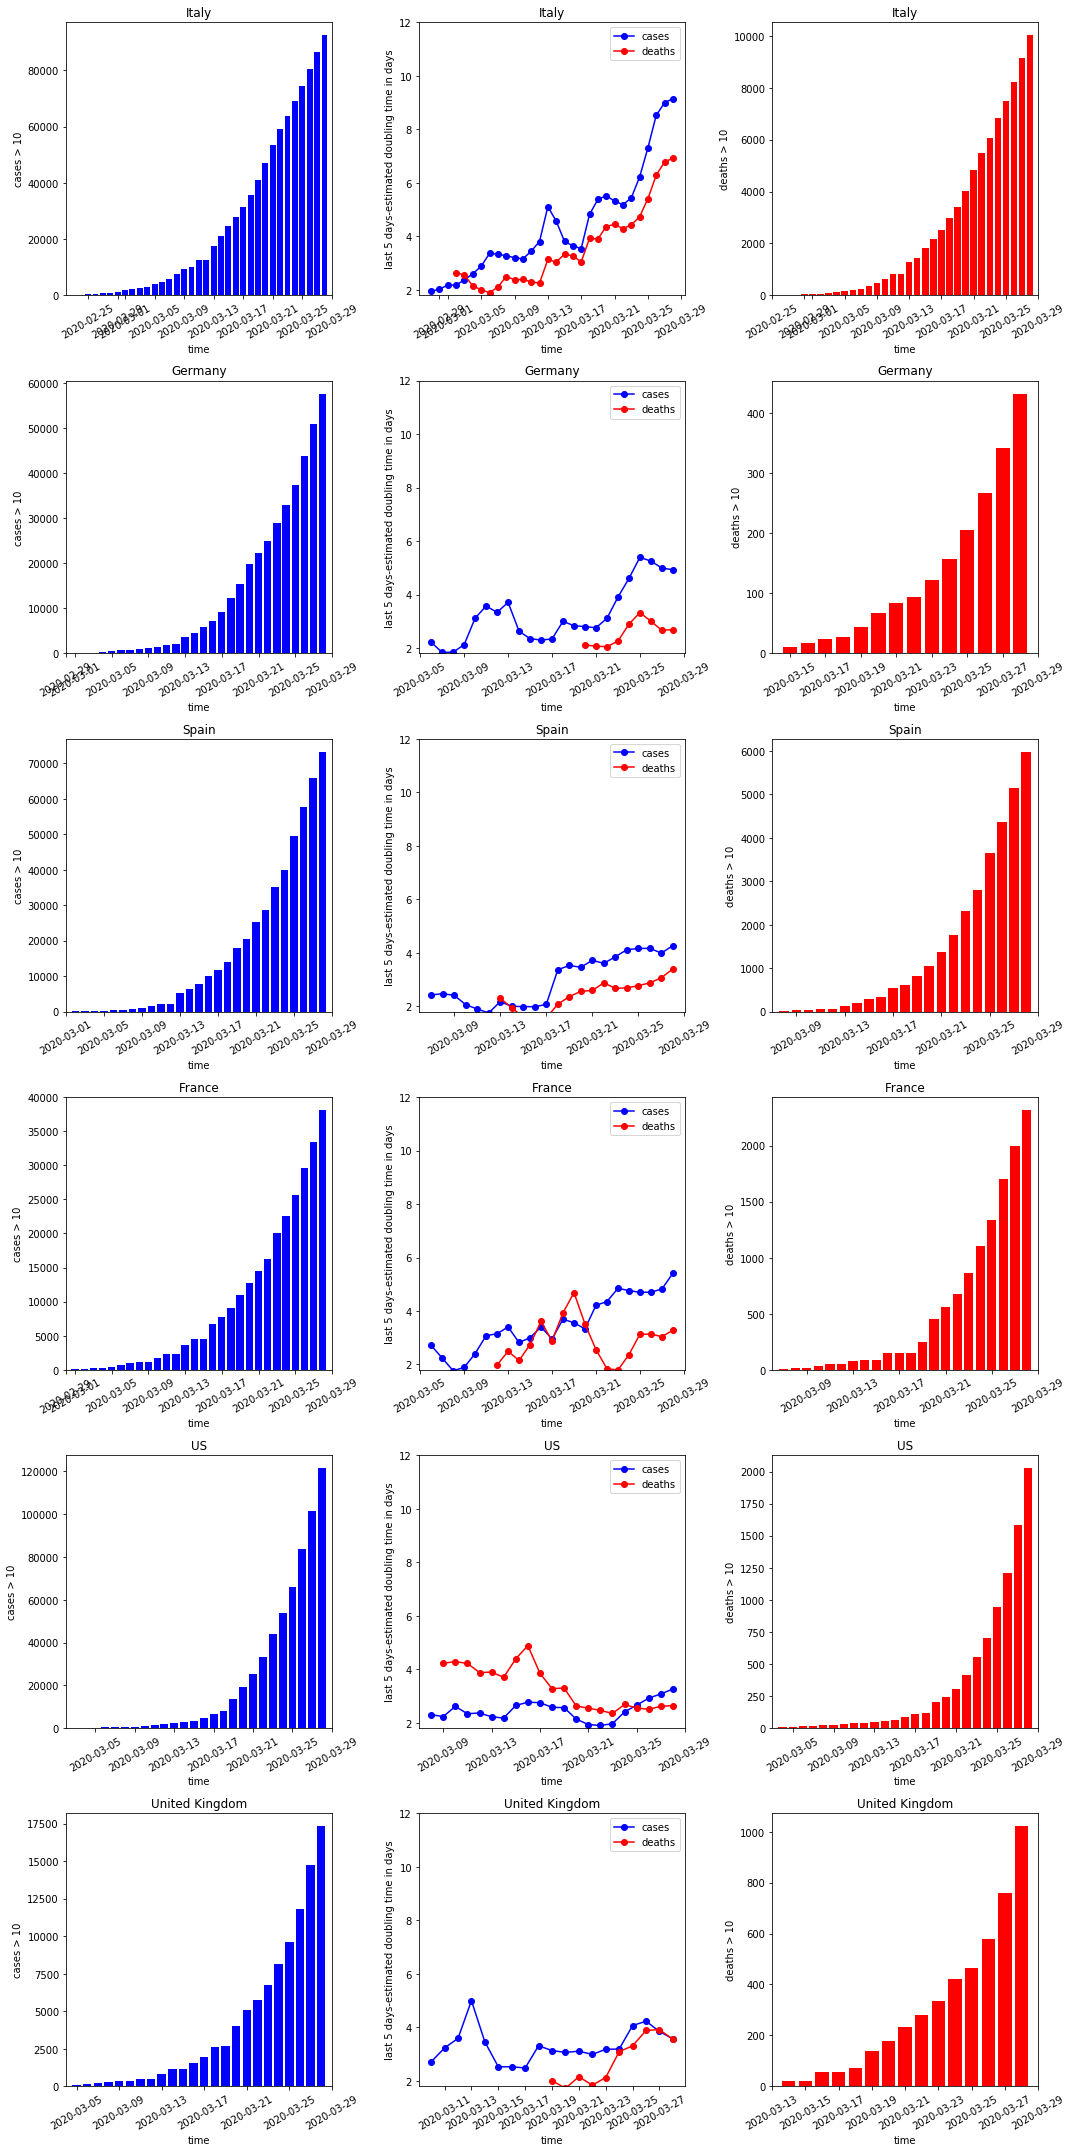

In [35]:
### plot country data
# choose country
ctyls=['Italy','Germany','Spain', 'France','US','United Kingdom']
#ctyls=['China','Korea','Germany']
datatypels=['cases','deaths']
plot_cty(ctyls = ctyls, datatypels = datatypels, inc=5, case_th=100, death_th=10, save=False)


0 0.4501583092656108 2.2214407230012085 0.06849801785322292
1 0.5448448152236313 1.8353849978173153 0.056156327088768616
2 0.5409277981433223 1.848675559718681 0.05792015077352517
3 0.4707051979680024 2.1244719716649016 0.06701972307463705
4 0.3207916544896124 3.117288077805594 0.027270139971810457
5 0.27991564053471407 3.572504909299571 0.015187246376693199
6 0.29980048751911265 3.335551613925407 0.01977769547838502
7 0.26953973629206623 3.710028115915444 0.023882858197421808
8 0.379990715638915 2.631643245068774 0.0589618303491973
9 0.42535247914413876 2.350991351953849 0.056321613597805416
10 0.4347221059354851 2.3003201041458077 0.05453681579048293
11 0.42713775018625366 2.3411651149165564 0.056578673961046
12 0.3331031409724705 3.002073162926571 0.0026727781633818395
13 0.3529392255536552 2.8333489949475057 0.009426957381569005
14 0.35664690935316745 2.80389363758584 0.008502084401422983
15 0.36239387415913704 2.7594285425500122 0.007471233090589349
16 0.32127471513365724 3.112601

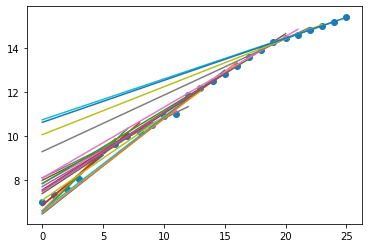

In [96]:
cty='Germany'; datatype='cases'
sample=data_gpd[data_gpd['country'].str.contains(cty)==True].iloc[:,2:].T
sample.index=pd.to_datetime(sample.index)
sample.columns=[datatype]
sub_sample=sample[sample[datatype] > 100]
sub_sample=sub_sample.reset_index()
xx=sub_sample.index
plt.scatter(xx, np.log2(sub_sample[datatype]))
el=0
inc=5
while el+inc < len(sub_sample):
    
    s,i,r,p,std = linregress(xx[el:el+inc], np.log2(sub_sample[datatype][el:el+inc]))
    print (el, s, 1/s, std)
    el=el+1
    plt.plot(xx[:el+inc],xx[:el+inc]*s+i)